# CipherWords

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [70]:
from itertools import combinations_with_replacement

In [2]:
from pathlib import Path

In [7]:
import nltk
import nltk.corpus

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/david/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [11]:
wnl = nltk.stem.WordNetLemmatizer()

In [12]:
stopwords = nltk.corpus.stopwords.words('english')

Define the list of keywords to use:

In [15]:
K = [w.strip().lower() for w in open('words.txt')]

A few keywords have spaces:

In [16]:
[k for k in K if ' ' in k]

['ice cream', 'loch ness', 'new york', 'scuba diver']

These could be implemented as a digram, which adds a lot of complexity for just a few words, or by removing the space, which requires a large enough training corpus to capture correlations with a less common form.  Instead, replace these words. We also replace a few words that have consistently obscure associations:

In [17]:
replacements = {
    # Compound words
    'ice cream': 'meringue',
    'loch ness': 'shetland',
    'new york': 'boston',
    'scuba diver': 'mariner',
    # Obscure associations
    'dice': 'roll', # dough, esta, hacer (spanish verbs)
    'leprechaun': 'jedi', # lovable, humpty, herriot (??)
    'straw': 'barley', #minister, secretary, condoleezza (Jack Straw was UK secretary of state)
    'undertaker': 'caregiver', # wrestling stuff
    'ray': 'lightsaber',
    'robin': 'condor',
    'angel': 'demon',
}
K = sorted([replacements.get(k, k) for k in K])

Load word frequencies for filtering out obscure words. We use [this list](https://github.com/hermitdave/FrequencyWords/blob/master/content/2018/en/en_full.txt) based on the [2018 open subtitles database](https://opus.nlpl.eu/OpenSubtitles2018.php), hosted [here](https://github.com/hermitdave/FrequencyWords). For more lists, see [here](https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists).

Loaded 1026874 word frequencies from en_full.txt


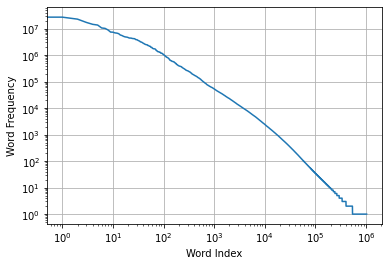

In [20]:
def load_freqs(filename='en_full.txt'):
    freqs = {}
    wordpat = re.compile('^[a-z]+$')
    with open(filename) as f:
        for line in f:
            word, f = line.split()
            if not wordpat.match(word.lower()):
                continue
            freqs[word.lower()] = float(f)
    print(f'Loaded {len(freqs)} word frequencies from {filename}')
    
    plt.plot(F.values())
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.ylabel('Word Frequency')
    plt.xlabel('Word Index')
    
    return freqs

F = load_freqs()

Download [GloVe word embedding vectors](https://nlp.stanford.edu/projects/glove/) pre-trained no Wikipedia 2014 + Gigaword 5, which are available in 50d, 100d, 200d, 300d. The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence, so this is our basis for estimating word similarity.

In [21]:
GLOVEDIR = Path('/Users/david/Data/Words/GLOVE')
assert GLOVEDIR.exists()

In [22]:
class GloveBox:
    def __init__(self, filename, ndim):
        self.ndim = ndim
        self.filename = GLOVEDIR / filename
        assert self.filename.exists()
    def __enter__(self):
        self.f = open(self.filename)
        return self
    def __exit__(self, *args):
        self.f.close()
    class Line:
        def __init__(self, line, ndim):
            self.word, *self.values = line.split()
            if len(self.values) != ndim:
                raise ValueError(f'Badly formed line with {len(self.values)} values: "{line}"')
            self._vec = None
        @property
        def vec(self):
            if self._vec is None:
                self._vec = np.array([float(val) for val in self.values], np.float32)
            return self._vec
    def lines(self):
        for line in self.f:
            try:
                yield GloveBox.Line(line, self.ndim)
            except ValueError:
                pass

An ad-hoc list of words that should be vetoed from the final clue dictionary.  See below for details on how this was determined.

In [23]:
vetos = 'miguel,jose,luis,jah,roy,tom,ken,jenson,canadian,centre,changing,chinese,comedy,odi,dancing,died,pero,una,\
facing,filing,flew,flown,french,greek,uss,himalayan,eh,gyula,ii,suge,zat,living,thing,mexican,bic,los,piracy,racquet,\
andy,jan,kibo,roman,tael,shooting,shoot,sank,km,solana,wwe,teaching,theatre,tying,teeth,turkish,lesnar,orton,oroton,\
debby,whaling,dpp,metre,jimenez,maria,kmt,charlie,showalter,mckeon,sah,ohl,satyajit,robert,joschka,cabrera,chuck,\
shawshank,quasimodo,radin,floyd,gordy,jiabao,persie,nwa,clitoral,lech,iii,nagin,mining,sri,buffy,ruud,juan,hank,\
luh,gah,kah,rss'.split(',')

This is where we build the clue dictionary...

In [24]:
def load(threshold=10, minfreq=50, ndim=100, filename='glove.6B/glove.6B.{ndim}d.txt', keywords=K, freqs=F):

    # First pass to load the vectors of all keywords.
    nkeys = len(keywords)
    keyvecs = np.empty((nkeys, ndim), np.float32)
    missing = list(keywords)
    filename = filename.format(ndim=ndim)
    with GloveBox(filename, ndim) as gb:
        for line in gb.lines():
            try:
                i = keywords.index(line.word)
                keyvecs[i] = line.vec
                missing.remove(line.word)
            except ValueError:
                continue
    if missing:
        print(f'Missing {len(missing)} keywords: {", ".join(missing)}.')
        return
    print(f'Located all {len(keywords)} keywords.')
    
    # Lemmatize all keywords.
    keylemmas = set([wnl.lemmatize(word) for word in keywords])
    
    # Keep track of clue lemmas.
    cluelemmas = []

    # Define a valid clue
    def valid_clue(clue):
        # Reject stop words.
        if clue in stopwords:
            return False
        # Reject words on our veto list.
        if clue in vetos:
            return False
        # Reject clues based on their part of speech
        pos = nltk.pos_tag([clue], tagset='universal')[0][1]
        if pos in ('ADP', 'CONJ', 'DET', 'PRT', 'PRON'):
            return False
        # Reject clues that are strictly containing or contained within any keyword
        for keyword in keywords:
            if (clue in keyword) or (keyword in clue):
                return False
        # Reject clues that have the same lemma as any keyword
        lemma = wnl.lemmatize(clue)
        if lemma in keylemmas:
            return False
        # Reject clues with the same lemma as a previous clue.
        if lemma in cluelemmas:
            return False
        # Remember this clue lemma.
        cluelemmas.append(lemma)
        return True

    # Second pass to measure keyword similarity of all possible clues.
    wordpat = re.compile('^[a-z]+$')
    cluewords, cluevecs = [], []
    with GloveBox(filename, ndim) as gb:
        for i, line in enumerate(gb.lines()):
            if line.word not in freqs or freqs[line.word] < minfreq:
                continue
            if not wordpat.match(line.word):
                continue
            # Calculate the log(prob) of this word co-ocurring with each keyword.
            logprobs = keyvecs.dot(line.vec)
            # Cut on the largest log(prob)
            if logprobs.max() < threshold:
                continue
            # Check that this clue is valid for all keywords.
            # We could relax this since a clue only needs to be valid for the keywords visible in a game
            # but that would add complexity in the game client.
            if not valid_clue(line.word):
                continue
            cluewords.append(line.word)
            cluevecs.append(line.vec)
    cluevecs = np.vstack(cluevecs)
    print(f'Selected {len(cluewords)} clue words, clue vectors size is {cluevecs.nbytes / (1<<20):.1f}Mb.')
    return cluewords, cluevecs, keyvecs

Generate clue dictionaries with 100, 200, 300 dimensional vectors that are all about 20Mb in size:

In [36]:
C100,CV100,KV100 = load(threshold=3, ndim=100)

Located all 400 keywords.
Selected 51247 clue words, clue vectors size is 19.5Mb.


In [34]:
C200,CV200,KV200 = load(threshold=10, ndim=200)

Located all 400 keywords.
Selected 25817 clue words, clue vectors size is 19.7Mb.


In [32]:
C300,CV300,KV300 = load(threshold=12.5, ndim=300)

Located all 400 keywords.
Selected 17052 clue words, clue vectors size is 19.5Mb.


In [44]:
def save(cluewords, cluevecs, keyvecs, path='../docs/data'):
    _,ndim = keyvecs.shape
    path = Path(path)
    assert path.exists()
    for (name,words,vecs) in (('clue', cluewords, cluevecs), ('key', K, keyvecs)):
        with open(path / f'{name}words_{ndim}d.txt', 'w') as out:
            print('\n'.join(words), file=out)
        with open(path / f'{name}vec_{ndim}d.txt', 'wb') as out:
            vecs.tofile(out)

In [45]:
save(C100,CV100,KV100)

In [46]:
save(C200,CV200,KV200)

In [47]:
save(C300,CV300,KV300)

In [48]:
def get_keyword_index(keyword, K):
    try:
        return K.index(keyword.lower())
    except ValueError:
        raise ValueError(f'{keyword} is not a keyword.')

Find the best clues given four groups of keywords: those belonging to us or our oponent, and the neutral and assasin groups. The weights are used to combine the similarities of each clue into an overall score. The alpha parameter controls how aggressive (larger values) to be in proposing clues for more words.

In [74]:
[list(set(x)) for x in combinations_with_replacement([0,1,2],2)]

[[0], [0, 1], [0, 2], [1], [1, 2], [2]]

In [ ]:
def unique_ntuples(vec, n, accum=[]):
    """Generate all unique n-tuples of the elements of vec.
    """
    for x in vec[:-n]:
        accum

In [69]:
def get_clues(groups, C, CV, KV, nbest=5, max_count=3, weights=[1, -1, -2, -4], alpha=0.5, verbose=True):
    
    tags = ('us', 'neutral', 'opponent', 'assasin')
    ngroups = len(tags)
    if len(groups) != ngroups:
        raise ValueError(f'Expected {len(tags)} groups.')    
    if verbose:
        for tag,words in zip(tags, groups):
            if(words):
                print(f'{tag} : {words}')

    # Find indexes of each keyword
    groups = [[get_keyword_index(keyword, K) for keyword in group] for group in groups]
    
    # Check for non-overlapping groups.
    all_groups = set()
    for i1, group1 in enumerate(groups):
        set1 = set(group1)
        if len(set1) != len(group1):
            raise ValueError(f'"{tags[i1]}" group has duplicate keyword.')
        all_groups |= set1
        for i2, group2 in enumerate(groups[i1+1:]):
            set2 = set(group2)
            if set1 & set2:
                raise ValueError(f'"{tags[i1]}" and "{tags[i1+i2+1]}" groups overlap.')
    all_groups = [K[i] for i in all_groups]
    
    # Generate all unique tuples of the elements of vec with length <= max_count.
    tuples = [list(set(x)) for x in combinations_with_replacement(all_groups[0], max_count)]

    similarity = np.zeros((ngroups, len(C)))

    # Calculate the joint similarity of the "selected" group for all possible clues.
    similarity[0] = np.dot(CV, KV[groups[0]].T).sum(axis=1)

    # Calculate the maximum similarity to any single word in the other groups.
    for i in range(1, ngroups):
        similarity[i] = np.max(np.dot(CV, KV[groups[i]].T), axis=1, initial=0)
    
    # Calculate the overall weighted score for all possible clues.
    score = np.dot(weights, similarity)
    
    # Find the clues with the highest score.
    order = np.argsort(score)[::-1]    
    best = []
    for i in order[:nbest]:
        best.append((C[i], score[i]))
    return best

Compare clues for the different dimensions:

In [57]:
get_clues((K[2:3], (), K[10:20], ()), C100, CV100, KV100)

us : ['air']
opponent : ['arm', 'atlantis', 'australia', 'aztec', 'back', 'ball', 'band', 'bank', 'bar', 'bark']


[('expeditionary', 7.98170280456543),
 ('bef', 7.734585762023926),
 ('bio', 5.563735365867615),
 ('ramstein', 5.409869194030762),
 ('marshal', 5.250202178955078)]

In [58]:
get_clues((K[2:3], (), K[10:20], ()), C200, CV200, KV200)

us : ['air']
opponent : ['arm', 'atlantis', 'australia', 'aztec', 'back', 'ball', 'band', 'bank', 'bar', 'bark']


[('ramstein', 14.993378639221191),
 ('osan', 13.666535496711731),
 ('luftwaffe', 12.166522979736328),
 ('onur', 10.827667713165283),
 ('conditioners', 10.574135780334473)]

In [59]:
get_clues((K[2:3], (), K[10:20], ()), C300, CV300, KV300)

us : ['air']
opponent : ['arm', 'atlantis', 'australia', 'aztec', 'back', 'ball', 'band', 'bank', 'bar', 'bark']


[('aviation', 12.58737850189209),
 ('onur', 12.011748552322388),
 ('klm', 10.518141269683838),
 ('expeditionary', 10.229999542236328),
 ('luftwaffe', 8.842961311340332)]

Manually scan the top-3 matches for each keyword individually, with no penalty for matching any other keywords, 
to assess clue quality and build a list of clues to veto, either because they are illegal (e.g. "centre" for "center") or too obscure (wikipedia knows biographical details of many obscure people).

In [65]:
def scan(C, CV, KV, nbest=3):
    for i in range(len(K)):
        rest = list(K)
        rest.remove(K[i])
        groups = (K[i:i+1], (), (), ())
        clues = [f'{clue[0]:18s}' for clue in get_clues(groups, C, CV, KV, nbest, verbose=False)]
        print(f'{K[i].upper():11s} : {" ".join(clues)}')

In [66]:
scan(C100, CV100, KV100)

AFRICA      : south              asia               nations           
AGENT       : fbi                manager            cia               
AIR         : military           squadron           artillery         
ALIEN       : extraterrestrial   creatures          evil              
ALPS        : pyrenees           slopes             ski               
AMAZON      : itunes             ebay               microsoft         
AMBULANCE   : paramedics         bus                wounded           
AMERICA     : world              united             asia              
ANTARCTICA  : glacier            expedition         mapped            
APPLE       : microsoft          intel              iphone            
ARM         : shoulder           leg                right             
ATLANTIS    : shuttle            astronauts         endeavour         
AUSTRALIA   : zealand            britain            wales             
AZTEC       : inca               mayan              vedic             
BACK  

In [67]:
scan(C200, CV200, KV200)

AFRICA      : south              zimbabwe           nations           
AGENT       : fbi                kgb                nfl               
AIR         : military           aviation           squadron          
ALIEN       : extraterrestrial   creatures          humanoid          
ALPS        : pyrenees           slopes             ski               
AMAZON      : itunes             kindle             ebay              
AMBULANCE   : paramedics         wounded            sirens            
AMERICA     : united             world              latin             
ANTARCTICA  : glacier            expedition         mcmurdo           
APPLE       : iphone             microsoft          intel             
ARM         : wrist              shoulder           leg               
ATLANTIS    : shuttle            astronauts         endeavour         
AUSTRALIA   : zealand            indies             britain           
AZTEC       : inca               mayan              tenochtitlan      
BACK  

In [68]:
scan(C300, CV300, KV300)

AFRICA      : south              zimbabwe           kenya             
AGENT       : fbi                unrestricted       kgb               
AIR         : aviation           military           squadron          
ALIEN       : extraterrestrial   creatures          humanoid          
ALPS        : pyrenees           slopes             ski               
AMAZON      : kindle             itunes             jungle            
AMBULANCE   : paramedics         stretcher          sirens            
AMERICA     : latin              united             asia              
ANTARCTICA  : glacier            mcmurdo            polar             
APPLE       : iphone             ipod               macintosh         
ARM         : wrist              shoulder           leg               
ATLANTIS    : shuttle            astronauts         endeavour         
AUSTRALIA   : zealand            sydney             wales             
AZTEC       : inca               mayan              tenochtitlan      
BACK  